In [21]:
%matplotlib inline

import numpy as np
import pandas as pd

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from pydub import AudioSegment
from pydub.utils import make_chunks

import re

In [121]:
# def get_features(data_dir, audio_files):
#     momentos = {'ducha': 'Ducha', 'cena': 'Cena', 'washing': 'Lavadora', 'vacuum': 'Aspiradora', 
#                 'shaver': 'Afeitadora', 'hairdryer': 'Secador_pelo', 'airconditioner': 'Aire_acondicionado', 
#                 'cellphone': 'Telefono', 'comp': 'Tecleo', 'silence': 'Silencio', 'dryer': 'Secadora', 
#                 'blender': 'Licuadora', 'doorbell': 'Timbre', 'alarm': 'Alarma', 'faucet': 'Grifo', 
#                 'microwave': 'Microondas'}
#     features = []
#     for i in range(len(audio_files)):
#         y, sr = librosa.load(audio_files[i], sr=8000, mono=True)
#         name = os.listdir(data_dir)[i]
#         pattern = "[._][\w]+"
#         name = re.sub(pattern, '', name)
#         if name in momentos.keys():
#             momento = momentos.get(name)
#         else:
#             momento = 'Otro'
#         D = np.abs(np.fft.fft(y, n=1024)[:8000 // 2]).tolist()
#         D.append(momento)
#         features.append(D)
#     data = pd.DataFrame()
#     for i in range(1025):
#         data[i] = i
#     for i in range(len(features)):
#         data = pd.concat([data, pd.DataFrame([features[i]])], ignore_index=True)
#     data.rename(index=str, columns={1024: "momento"}, inplace=True)
#     return data

# data = get_features('./audios/fourier_32/', glob('./audios/fourier_32' + '/*.wav'))

In [ ]:
def get_features(data_dir, audio_files):
    momentos = {'ducha': 'Ducha', 'cena': 'Cena', 'washing': 'Lavadora', 'vacuum': 'Aspiradora', 
                'shaver': 'Afeitadora', 'hairdryer': 'Secador_pelo', 'airconditioner': 'Aire_acondicionado', 
                'cellphone': 'Telefono', 'comp': 'Tecleo', 'silence': 'Silencio', 'dryer': 'Secadora', 
                'blender': 'Licuadora', 'doorbell': 'Timbre', 'alarm': 'Alarma', 'faucet': 'Grifo', 
                'microwave': 'Microondas'}
    features = []
    for i in range(len(audio_files)):
        y, sr = librosa.load(audio_files[i], sr=8000, mono=True)
        name = os.listdir(data_dir)[i]
        pattern = "[._][\w]+"
        name = re.sub(pattern, '', name)
        if name in momentos.keys():
            momento = momentos.get(name)
        else:
            momento = 'Otro'
        mfcc = np.ndarray.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
        scem = np.ndarray.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        scom = np.ndarray.mean(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y)), sr=sr, n_bands=4))
        srom = np.ndarray.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        sbwm = np.ndarray.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        tempo = librosa.beat.tempo(onset_envelope=librosa.onset.onset_strength(y=y, sr=sr, hop_length=512), sr=sr, hop_length=512)[0]
        rmse = np.ndarray.mean(librosa.feature.rms(y=y))
        D = np.abs(librosa.stft(y)).tolist()
        for i in range(len(D)):
            D[i] = np.mean(D[i])
        features_list = [mfcc, scem, scom, srom, sbwm, tempo, rmse, momento]
        for i in features_list:
            D.append(i)
        features.append(D)
    data = pd.DataFrame()
    for i in range(1026):
        data[i] = i
    for i in range(len(features)):
        data = pd.concat([data, pd.DataFrame([features[i]])], ignore_index=True)
    data.rename(index=str, columns={1025: "mfcc", 1026: 'scem', 1027: 'scom', 1028: 'srom', 
                                    1029: 'sbwm',1030: 'tempo', 1031: 'rmse', 1032: 'momento'}, inplace=True)
    return data

data = get_features('./audios/fourier_32/', glob('./audios/fourier_32' + '/*.wav'))

In [32]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1023,1024,momento,mfcc,scem,scom,srom,sbwm,tempo,rmse
0,0.146137,0.115654,0.062066,0.064627,0.081702,0.076550,0.042299,0.049996,0.048277,0.028199,...,0.000700,0.000641,-19.602940,1016.689071,28.116497,1344.604492,526.793735,117.187500,0.082146,Timbre
1,0.043638,0.044245,0.044882,0.043757,0.043269,0.043084,0.041995,0.041291,0.042194,0.043316,...,0.005225,0.005301,-23.112227,1361.218925,25.115322,2646.606445,1025.292241,117.187500,0.055449,Cena
2,1.824585,2.439606,3.887073,4.413875,2.713577,3.409098,8.645504,10.691982,5.270561,6.056281,...,0.008759,0.008697,4.153023,662.289054,21.617422,1497.436523,832.083155,156.250000,0.240111,Lavadora
3,0.056518,0.063907,0.065764,0.069703,0.066394,0.072831,0.067736,0.057306,0.055959,0.056930,...,0.009799,0.009868,-15.240392,1539.737568,22.446293,2865.844727,1002.431942,133.928571,0.113920,Secador_pelo
4,1.071831,1.078270,1.239673,1.441809,1.476215,1.300763,1.610223,3.292089,9.517521,19.414401,...,0.001807,0.001760,6.963927,582.127562,19.931546,1348.144531,798.607193,133.928571,0.212797,Aire_acondicionado


In [44]:
data = data.rename(index=str, columns={"momento": "rmse1", "rmse": "momento1"})
data = data.rename(index=str, columns={"rmse1": "rmse", "momento1": "momento"})
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1023,1024,rmse,mfcc,scem,scom,srom,sbwm,tempo,momento
0,0.146137,0.115654,0.062066,0.064627,0.081702,0.076550,0.042299,0.049996,0.048277,0.028199,...,0.000700,0.000641,-19.602940,1016.689071,28.116497,1344.604492,526.793735,117.187500,0.082146,Timbre
1,0.043638,0.044245,0.044882,0.043757,0.043269,0.043084,0.041995,0.041291,0.042194,0.043316,...,0.005225,0.005301,-23.112227,1361.218925,25.115322,2646.606445,1025.292241,117.187500,0.055449,Cena
2,1.824585,2.439606,3.887073,4.413875,2.713577,3.409098,8.645504,10.691982,5.270561,6.056281,...,0.008759,0.008697,4.153023,662.289054,21.617422,1497.436523,832.083155,156.250000,0.240111,Lavadora
3,0.056518,0.063907,0.065764,0.069703,0.066394,0.072831,0.067736,0.057306,0.055959,0.056930,...,0.009799,0.009868,-15.240392,1539.737568,22.446293,2865.844727,1002.431942,133.928571,0.113920,Secador_pelo
4,1.071831,1.078270,1.239673,1.441809,1.476215,1.300763,1.610223,3.292089,9.517521,19.414401,...,0.001807,0.001760,6.963927,582.127562,19.931546,1348.144531,798.607193,133.928571,0.212797,Aire_acondicionado


In [45]:
data = data[data[2] != 0].reset_index(drop=True)

KeyError: 2

In [46]:
def show_df_info(dataframe):
    display("The type of the dataframe is {}.".format(type(dataframe)))
    print("------------------------------------------------------------------------")
    display("The amount of entries are {}.".format(dataframe.size))
    print("------------------------------------------------------------------------")
    display("Its shape is {}.".format(dataframe.shape))
    print("------------------------------------------------------------------------")
    display("Its features are: {}.".format(list(dataframe)))
    print("------------------------------------------------------------------------")
    print("The data types of columns are: {}".format(dataframe.dtypes))
    print("------------------------------------------------------------------------")
    print("The counter of each class is: {}".format(dataframe.momento.value_counts()))
    print("------------------------------------------------------------------------")
    print('The amount of null values is: {}.'.format(dataframe.isna().sum()))
    display(dataframe.head())
    display(dataframe.describe())
    
show_df_info(data)

"The type of the dataframe is <class 'pandas.core.frame.DataFrame'>."

------------------------------------------------------------------------


'The amount of entries are 15050810.'

------------------------------------------------------------------------


'Its shape is (14570, 1033).'

------------------------------------------------------------------------


"Its features are: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155'

------------------------------------------------------------------------
The data types of columns are: 0          float64
1          float64
2          float64
3          float64
4          float64
5          float64
6          float64
7          float64
8          float64
9          float64
10         float64
11         float64
12         float64
13         float64
14         float64
15         float64
16         float64
17         float64
18         float64
19         float64
20         float64
21         float64
22         float64
23         float64
24         float64
25         float64
26         float64
27         float64
28         float64
29         float64
            ...   
1003       float64
1004       float64
1005       float64
1006       float64
1007       float64
1008       float64
1009       float64
1010       float64
1011       float64
1012       float64
1013       float64
1014       float64
1015       float64
1016       float64
1017       float64
1018       float64
101

,0,1,2,3,4,5,6,7,8,9,...,1023,1024,rmse,mfcc,scem,scom,srom,sbwm,tempo,momento
0,0.146137,0.115654,0.062066,0.064627,0.081702,0.076550,0.042299,0.049996,0.048277,0.028199,...,0.000700,0.000641,-19.602940,1016.689071,28.116497,1344.604492,526.793735,117.187500,0.082146,Timbre
1,0.043638,0.044245,0.044882,0.043757,0.043269,0.043084,0.041995,0.041291,0.042194,0.043316,...,0.005225,0.005301,-23.112227,1361.218925,25.115322,2646.606445,1025.292241,117.187500,0.055449,Cena
2,1.824585,2.439606,3.887073,4.413875,2.713577,3.409098,8.645504,10.691982,5.270561,6.056281,...,0.008759,0.008697,4.153023,662.289054,21.617422,1497.436523,832.083155,156.250000,0.240111,Lavadora
3,0.056518,0.063907,0.065764,0.069703,0.066394,0.072831,0.067736,0.057306,0.055959,0.056930,...,0.009799,0.009868,-15.240392,1539.737568,22.446293,2865.844727,1002.431942,133.928571,0.113920,Secador_pelo
4,1.071831,1.078270,1.239673,1.441809,1.476215,1.300763,1.610223,3.292089,9.517521,19.414401,...,0.001807,0.001760,6.963927,582.127562,19.931546,1348.144531,798.607193,133.928571,0.212797,Aire_acondicionado


,0,1,2,3,4,5,6,7,8,9,...,1022,1023,1024,rmse,mfcc,scem,scom,srom,sbwm,tempo
count,14570.000000,14570.000000,14570.000000,14570.000000,14570.000000,1.457000e+04,1.457000e+04,1.457000e+04,1.457000e+04,1.457000e+04,...,1.457000e+04,1.457000e+04,1.457000e+04,14570.000000,14570.000000,14570.000000,14570.000000,14570.000000,14570.000000,1.457000e+04
mean,1.144880,1.605762,2.342925,2.055249,1.781320,1.821342e+00,2.626093e+00,2.860539e+00,2.084397e+00,2.147706e+00,...,5.325582e-03,5.496566e-03,5.613336e-03,-9.139711,1246.126583,22.268031,2234.551027,886.770769,130.397828,9.004050e-02
std,2.429249,3.972752,7.722088,5.426192,4.214954,4.520177e+00,7.796046e+00,7.915803e+00,4.785317e+00,5.037363e+00,...,5.879420e-03,7.014858e-03,1.028536e-02,10.216578,556.704340,3.301272,817.561371,203.002645,19.977244,8.279924e-02
min,0.000009,0.000009,0.000002,0.000005,0.000001,7.362351e-07,2.278805e-07,5.702340e-07,1.322276e-07,9.737943e-08,...,1.897780e-09,2.473457e-09,2.657786e-09,-56.466742,165.311560,1.385253,291.259766,101.931160,37.500000,4.280168e-08
25%,0.072454,0.081966,0.063023,0.062917,0.062998,6.256553e-02,6.039495e-02,6.111843e-02,6.186935e-02,6.473866e-02,...,1.287143e-03,1.330012e-03,1.277079e-03,-16.561278,777.578104,19.934503,1495.361328,801.127642,117.187500,1.989964e-02
50%,0.191644,0.227856,0.184395,0.188727,0.233663,2.476937e-01,2.595164e-01,2.443536e-01,2.330167e-01,2.454220e-01,...,3.469993e-03,3.573854e-03,3.488704e-03,-8.216509,1275.436837,21.851786,2343.322754,924.434519,133.928571,6.897597e-02
75%,0.791609,0.748850,0.757068,1.019724,1.056351,1.111747e+00,1.028586e+00,1.027576e+00,1.015509e+00,1.146846e+00,...,7.562025e-03,7.649565e-03,7.681961e-03,-3.105345,1730.507136,23.718120,2829.071045,1037.323614,133.928571,1.367395e-01
max,70.510727,35.161152,56.872029,37.459987,44.733345,3.631372e+01,5.822164e+01,5.580385e+01,5.181629e+01,5.037065e+01,...,1.875849e-01,2.933370e-01,5.987769e-01,8.775053,2707.461116,51.275412,3609.375000,1299.501746,312.500000,5.108476e-01


In [47]:
data.to_csv('TEST.csv', index=False)

In [48]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

import pickle

In [49]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('TEST.csv')

In [50]:
y = pd.get_dummies(data=data.momento)
X = data.loc[:, data.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [51]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
# scores = cross_val_score(model, X, y, cv=10)
# print(scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [52]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9852436513383666

In [53]:
filename = 'TEST_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [54]:
predictions = model.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.0
Aire_acondicionado    0.0
Alarma                0.0
Aspiradora            0.0
Cena                  0.0
Ducha                 0.0
Grifo                 0.0
Lavadora              0.0
Licuadora             0.0
Microondas            0.0
Secador_pelo          0.0
Secadora              0.0
Silencio              0.0
Tecleo                0.0
Telefono              0.0
Timbre                0.0
dtype: float64 degrees.


In [55]:
actual_values = y_test.values.argmax(axis=1)
predictions = model.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9852436513383666

In [56]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9850338105951246

In [57]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento'
precision_recall

,precision,recall,f1_score
momento,,,
Cena,0.816514,1.000000,0.898990
Ducha,1.000000,0.995000,0.997494
Lavadora,1.000000,0.988889,0.994413
Aspiradora,1.000000,0.970060,0.984802
Afeitadora,1.000000,0.970803,0.985185
Secador_pelo,0.994536,0.978495,0.986450
Aire_acondicionado,1.000000,0.941520,0.969880
Telefono,1.000000,0.987069,0.993492
Tecleo,1.000000,0.957547,0.978313


Confusion matrix, without normalization
[[178   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 199   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0 178   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   0 162   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0 133   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0   0 182   0   0   0   0   0   0   0   0   0   0]
 [  9   0   0   0   0   1 161   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0 229   0   0   0   0   0   1   0   0]
 [  8   0   0   0   0   0   0   0 203   0   0   0   0   1   0   0]
 [  2   0   0   0   0   0   0   0   0 187   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 170   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 203   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 167   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0 195   0   0]
 [  2   0   0   0   0 

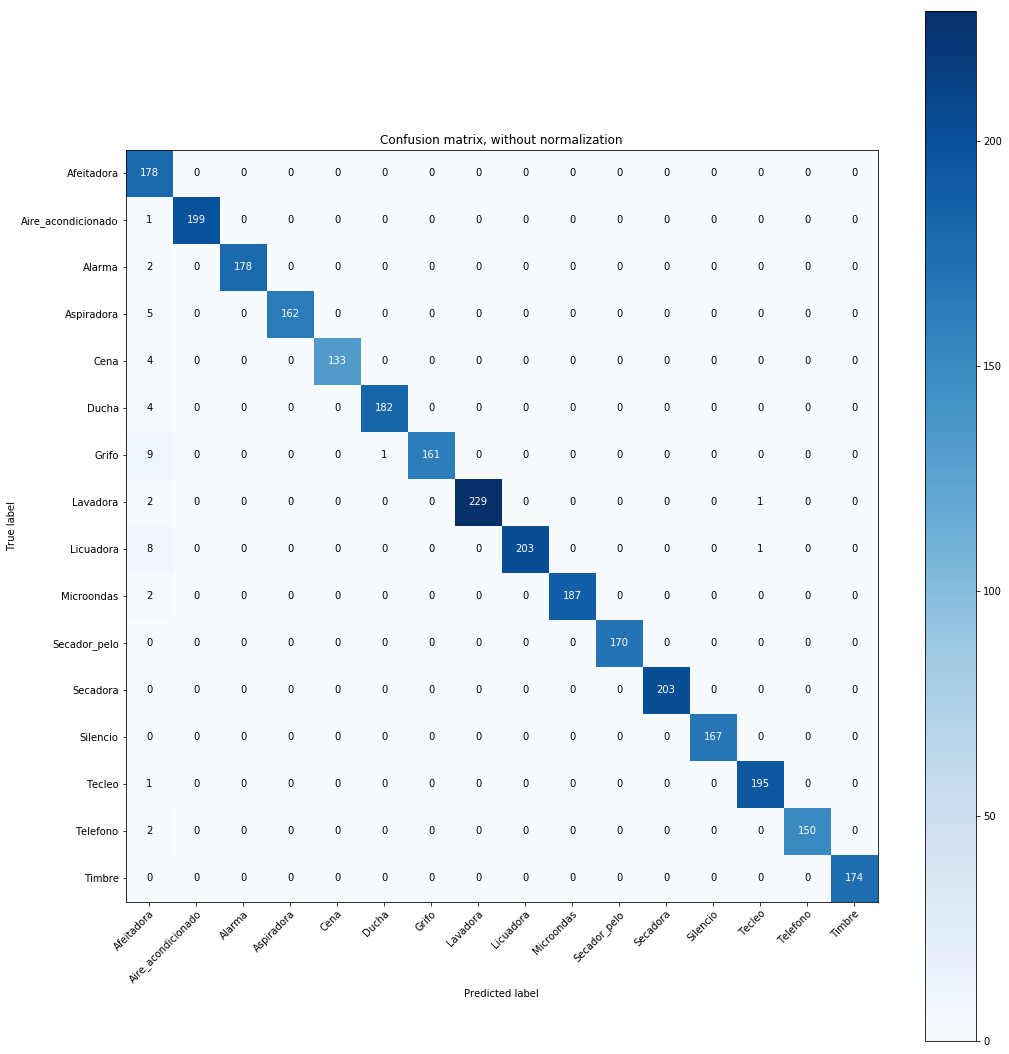

In [58]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [59]:
import numpy as np
import pandas as pd
import pandas.io

import re

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pydub import AudioSegment
from pydub.utils import make_chunks

import pickle

In [60]:
filename = 'TEST_model.sav'

loaded_model = pickle.load(open(filename, 'rb'))

In [62]:
def get_features(data_dir, audio_files):
    momentos = {'ducha': 'Ducha', 'cena': 'Cena', 'washing': 'Lavadora', 'vacuum': 'Aspiradora', 
                'shaver': 'Afeitadora', 'hairdryer': 'Secador_pelo', 'airconditioner': 'Aire_acondicionado', 
                'cellphone': 'Telefono', 'comp': 'Tecleo', 'silence': 'Silencio', 'dryer': 'Secadora', 
                'blender': 'Licuadora', 'doorbell': 'Timbre', 'alarm': 'Alarma', 'faucet': 'Grifo', 
                'microwave': 'Microondas'}
    features = []
    for i in range(len(audio_files)):
        y, sr = librosa.load(audio_files[i], sr=8000, mono=True)
        name = os.listdir(data_dir)[i]
        pattern = "[._][\w]+"
        name = re.sub(pattern, '', name)
        if name in momentos.keys():
            momento = momentos.get(name)
        else:
            momento = 'Otro'
        mfcc = np.ndarray.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
        scem = np.ndarray.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        scom = np.ndarray.mean(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y)), sr=sr, n_bands=4))
        srom = np.ndarray.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        sbwm = np.ndarray.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        tempo = librosa.beat.tempo(onset_envelope=librosa.onset.onset_strength(y=y, sr=sr, hop_length=512), sr=sr, hop_length=512)[0]
        rmse = np.ndarray.mean(librosa.feature.rms(y=y))
        D = np.abs(librosa.stft(y)).tolist()
        for i in range(len(D)):
            D[i] = np.mean(D[i])
        features_list = [mfcc, scem, scom, srom, sbwm, tempo, rmse, momento]
        for i in features_list:
            D.append(i)
        features.append(D)
    data = pd.DataFrame()
    for i in range(1026):
        data[i] = i
    for i in range(len(features)):
        data = pd.concat([data, pd.DataFrame([features[i]])], ignore_index=True)
#     data.rename(index=str, columns={1025: "mfcc", 1026: 'scem', 1027: 'scom', 1028: 'srom', 
#                                     1029: 'sbwm',1030: 'tempo', 1031: 'rmse', 1032: 'momento'}, inplace=True)
    data.rename(index=str, columns={1025: "rmse", 1026: 'mfcc', 1027: 'scem', 1028: 'scom', 
                                    1029: 'srom',1030: 'sbwm', 1031: 'tempo', 1032: 'momento'}, inplace=True)
    return data

prueba = get_features('./audios/predicciones_fourier_32/', glob('./audios/predicciones_fourier_32' + '/*.wav'))

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/linuxbrew/.linuxbre

In [64]:
prueba = prueba[prueba[2] != 0].reset_index(drop=True)

In [66]:
prueba.head()

,0,1,2,3,4,5,6,7,8,9,...,1023,1024,rmse,mfcc,scem,scom,srom,sbwm,tempo,momento
0,2.531651,1.265199,0.039410,0.044071,0.051338,0.040962,0.042103,0.044019,0.045022,0.059954,...,0.001789,0.001802,-14.789252,1307.712330,22.329178,2490.112305,941.869915,117.187500,0.029125,Lavadora
1,2.348727,1.160417,0.034879,0.767507,1.940031,1.180487,0.112131,0.605423,1.920090,1.447484,...,0.047961,0.093864,-2.996813,1181.177661,33.464148,3242.187500,1190.281966,120.000000,0.085731,Microondas
2,1.246561,1.897304,2.221308,1.851266,1.741688,1.156935,0.688204,0.580924,0.792271,1.020770,...,0.006618,0.006286,-2.807277,1409.495596,23.275813,2779.785156,1055.763228,133.928571,0.096703,Aspiradora
3,0.040482,0.061919,0.072617,0.057148,0.072702,0.067119,0.062169,0.082436,0.104883,0.069944,...,0.001589,0.001587,-16.530776,707.460976,23.874835,747.314453,440.637551,133.928571,0.017683,Timbre
4,0.259839,0.499467,0.601189,0.579121,0.910601,1.068486,0.586983,0.431582,0.409860,0.462054,...,0.004051,0.003785,-4.882842,1925.234669,19.538132,3061.645508,968.023202,133.928571,0.038148,Ducha


In [65]:
classes = ['Afeitadora', 'Aire_acondicionado', 'Alarma', 'Aspiradora', 'Cena', 'Ducha', 'Grifo', 'Lavadora', 
           'Licuadora', 'Microondas', 'Secador_pelo', 'Secadora', 'Silencio', 'Tecleo', 'Telefono', 'Timbre']

X_new = prueba.loc[:, prueba.columns != 'momento']
y_new = loaded_model.predict(X_new)
y_new2 = loaded_model.predict_proba(X_new)

reconocidos = 0
aciertos = 0
for i in range(len(X_new)):
    predicted_list = y_new[i].tolist()
    predicted_class = classes[y_new2[i].tolist().index(max(y_new2[i]))]
    predicted_probability = y_new2[i].tolist()[y_new2[i].tolist().index(max(y_new2[i]))]
    if max(y_new2[i]) > 0:
        if predicted_class == prueba.momento[i]:
            #print(str(i) + '-  {}: {:.2f}% ----> {}'.format(predicted_class, predicted_probability*100, prueba.momento[i]))
            aciertos += 1
            reconocidos += 1
        else:
            #print(str(i) + '-  {}: {:.2f}% ----> {}'.format(predicted_class, predicted_probability*100, prueba.momento[i]))
            reconocidos += 1


print('Porcentaje de sonidos reconocidos: {:.2f}%.'.format(reconocidos/(len(X_new))*100))
print('Porcentaje de aciertos: {:.2f}%.'.format(aciertos/(len(X_new))*100))
print('Porcentaje de aciertos una vez reconoce el sonido: {:.2f}%.'.format(aciertos/reconocidos*100))

Porcentaje de sonidos reconocidos: 100.00%.
Porcentaje de aciertos: 43.69%.
Porcentaje de aciertos una vez reconoce el sonido: 43.69%.


In [67]:
lista = [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]
newDF = pd.DataFrame()
for i in range(5):
    newDF[i] = i
for i in range(len(lista)):
    #newDF.iloc[:, i] = lista[i]
    newDF.loc[i] = lista[i]
    
newDF

,0,1,2,3,4
0,1,2,3,4,5
1,6,7,8,9,10


In [68]:
lista = [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

for i in range(len(lista)):
    newDF = pd.concat([newDF, pd.DataFrame([lista[i]])], ignore_index=True)

newDF

,0,1,2,3,4
0,1,2,3,4,5
1,6,7,8,9,10
2,1,2,3,4,5
3,6,7,8,9,10
